In [1]:
import os, pickle, random, sys
import tensorflow as tf
#tf.compat.v1.enable_v2_behavior()
#tf.enable_eager_execution()
#tf.compat.v1.disable_eager_execution()


sys.path.append('D:\\zhaixu\\Thesis_Code\\dl_amc_defense_seq')
sys.path.append('D:\\zhaixu\\Thesis_Code')


# log_print = open('Defalust.log', 'w')
# sys.stdout = log_print
# sys.stderr = log_print

import warnings
import copy
warnings.filterwarnings('ignore')
import numpy as np
import argparse
from matplotlib import pyplot as plt

import mltools

from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd, add_single_bd, insert_image
from art.utils import load_mnist, preprocess
from art.defences.detector.poison import ActivationDefence
from art.defences.transformer.poisoning import NeuralCleanse
from art.estimators.poison_mitigation import KerasNeuralCleanse
from sklearn.model_selection import train_test_split

from trigger_config import load_data
from trigger_config import set_trigger_config

D:\Anaconda3\envs\AMC\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
D:\Anaconda3\envs\AMC\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
D:\Anaconda3\envs\AMC\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


channels_last
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1, 128, 2)         0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 1, 132, 2)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1, 132, 256)       3328      
_________________________________________________________________
dropout (Dropout)            (None, 1, 132, 256)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 1, 136, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 136, 80)        122960    
___________________________

Using TensorFlow backend.


In [2]:
from tensorflow import keras
from sklearn.preprocessing import normalize  # Adjust based on your preprocessing needs

In [3]:
def get_conv_index(model):
    # getting all indices where layer is convolutional layer
    convindex = []
    for i in range(len(model.layers)):
        layer = model.get_layer(index=i)
        if isinstance(layer, keras.layers.Conv2D) or isinstance(layer, keras.layers.Conv1D):
            convindex.append(i)
    return convindex

In [4]:
def fineprune(model, x):
    # 存储卷积层权重
    layer_weights = []
    convindex = get_conv_index(model)
    for i in convindex:
        layer_weights.append(model.layers[i].get_weights()[0])
    
    # 计算每个卷积层的最小权重阈值
    min_weights_thr = []
    for i in range(len(convindex)):
        min_weights_thr.append(calc_bottom_X_percent_weight(layer_weights[i], x))
    
    # 对每个卷积层进行权重修剪
    new_weights = []
    for i in range(len(convindex)):
        new_weights.append(clear_min_weights(layer_weights[i], min_weights_thr[i]))
    
    # 构建卷积层索引映射
    map_indices = {}
    for i in range(len(convindex)):
        map_indices[i] = convindex[i]
    
    # 为了更新权重和偏置，构建一个包含权重和偏置的列表
    weights_biases = [0 for x in range(2)]
    
    # 更新模型的卷积层权重
    for key in map_indices:
        bias_weights = model.layers[map_indices[key]].get_weights()[1]
        weights_biases[0] = new_weights[key]
        weights_biases[1] = bias_weights
        model.layers[map_indices[key]].set_weights(weights_biases)
        
    return model

In [5]:
def evaluation(model,X_test, Y_test,test_idx,mods,snrs,lbl):
    classes = mods
    acc = []
    for snr in snrs:

        # extract classes @ SNR
        test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
        test_X_i = X_test[np.where(np.array(test_SNRs) == snr)]
        test_Y_i = Y_test[np.where(np.array(test_SNRs) == snr)]

        # estimate classes
        test_Y_i_hat = model.predict(test_X_i)
        conf = np.zeros([len(classes), len(classes)])

        for i in range(0, test_X_i.shape[0]):
            j = list(test_Y_i[i, :]).index(1)
            k = int(np.argmax(test_Y_i_hat[i, :]))
            conf[j, k] = conf[j, k] + 1

        cor = np.sum(np.diag(conf))
        ncor = np.sum(conf) - cor
        #print("Overall Accuracy: ", cor / (cor+ncor))
        print("snr:",snr,"acc:",cor / (cor + ncor))
        acc.append(1.0 * cor / (cor + ncor))
    acc_mean = sum(acc) / len(acc)
    print('acc_mean: ',acc_mean)
    acc.append(acc_mean)
    return acc

In [6]:
# 计算权重底部 X 百分比的函数
def calc_bottom_X_percent_weight(weights, fraction):
    # 初始化最大值和最小值为权重张量的第一个元素
    max = weights[0][0][0][0]
    min = weights[0][0][0][0]
    
    # 遍历权重张量的所有元素，找到最大值和最小值
    for i in range(len(weights)):
        for j in range(len(weights[i])):
            for k in range(len(weights[i][j])):
                for m in range(len(weights[i][j][k])):
                    if weights[i][j][k][m] < min:
                        min = weights[i][j][k][m]
                    if weights[i][j][k][m] > max:
                        max = weights[i][j][k][m]
    
    # 根据给定的百分比计算底部 X 百分比的权重
    truemin = min + (fraction * (max - min))
    
    # 返回计算得到的底部 X 百分比的权重
    return truemin

In [7]:
# 将权重张量中小于指定阈值的元素清零的函数
def clear_min_weights(weights, thresh):
    # 遍历权重张量的所有元素
    for i in range(len(weights)):
        for j in range(len(weights[i])):
            for k in range(len(weights[i][j])):
                for m in range(len(weights[i][j][k])):
                    # 如果元素值小于阈值，则将其置为 0
                    if weights[i][j][k][m] < thresh:
                        weights[i][j][k][m] = 0
                        
    # 返回更新后的权重张量
    return weights

In [8]:
# load data
X_train,X_test,Y_train,Y_test,mods,lbl,snrs,train_idx,test_idx = load_data()

X_train_modified, Y_train_modified = set_trigger_config(X_train.copy(), Y_train.copy(), pos_rate=0.1,
                                                        trigger_type="remapped_awgn", data_type='train')

x_train, x_val, y_train, y_val = train_test_split(X_train_modified, Y_train_modified, test_size=0.111,
                                                  random_state=42)

110000
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18]
['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
Poisoned training data.


In [9]:
# load model
from tensorflow.keras.models import load_model
#poisoned_model = load_model('D:/zhaixu/Thesis_Code/dl_amc_backdoor/all_to_one/saved_model/posioned_'+ args.MODEL_NAME + '_Hanning_EPOCH_100_POS_RATE_0.1.h5')

root_path = 'D:/zhaixu/Thesis_Code/dl_amc_backdoor/all_to_one/saved_model/'
#pos_model_name = f"{args.MODEL_NAME}_{args.TRIGGER_TYPE}_{args.POS_RATE}_{args.EPOCH}"
#poisoned_model = load_model(root_path + pos_model_name + '.h5')
poisoned_model = load_model(root_path + 'CNN2_spectrum_shift_0.1_100.h5')
poisoned_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 128, 1)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 2, 128, 256)       4352      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 64, 256)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 2, 64, 256)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 2, 64, 128)        524416    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 32, 128)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 2, 32, 128)        0   

In [10]:
# reshape train input
input_shape = poisoned_model.get_input_shape_at(0)
X_train = X_train.reshape((X_train.shape[0],) + tuple(input_shape[1:]))
X_train_modified = X_train_modified.reshape((X_train_modified.shape[0],) + tuple(input_shape[1:]))
x_train = x_train.reshape((x_train.shape[0],) + tuple(input_shape[1:]))
x_val = x_val.reshape((x_val.shape[0],) + tuple(input_shape[1:]))

In [11]:
from shutil import copyfile, move
# Loading the new weights in a temp model
copyfile(root_path + 'CNN2_spectrum_shift_0.1_100.h5', root_path +'temp_bd_net.h5')
model_BadNet_new = load_model(root_path +'temp_bd_net.h5')

In [12]:
# no defense
print('No defense eval\n')
X_test_benign = X_test.reshape((X_test.shape[0],) + tuple(input_shape[1:]))

X_test_modified, Y_test_modified = set_trigger_config(X_test.copy(), Y_test.copy(), pos_rate=0.1,
                                                        trigger_type="spectrum_shift", data_type='test')

X_test_modified = X_test_modified.reshape((X_test_modified.shape[0],) + tuple(input_shape[1:]))

print('CA')
acc_ca_no_defense = evaluation(poisoned_model,X_test_benign,Y_test,test_idx,mods,snrs,lbl)
print('ASR')
acc_asr_no_defense = evaluation(poisoned_model,X_test_modified,Y_test_modified,test_idx,mods,snrs,lbl)

No defense eval

Evaluate ASR on poisoned test data.
CA
snr: 0 acc: 0.8207816968541468
snr: 2 acc: 0.8586142322097379
snr: 4 acc: 0.8493392070484581
snr: 6 acc: 0.8539944903581267
snr: 8 acc: 0.8640692640692641
snr: 10 acc: 0.8393829401088929
snr: 12 acc: 0.8611361587015329
snr: 14 acc: 0.8536139066788655
snr: 16 acc: 0.8522622345337026
snr: 18 acc: 0.8854073410922113
acc_mean:  0.8538601471654939
ASR
snr: 0 acc: 0.8045757864632984
snr: 2 acc: 0.8632958801498127
snr: 4 acc: 0.9013215859030838
snr: 6 acc: 0.9320477502295684
snr: 8 acc: 0.9428571428571428
snr: 10 acc: 0.9301270417422868
snr: 12 acc: 0.9386834986474302
snr: 14 acc: 0.939615736505032
snr: 16 acc: 0.9473684210526315
snr: 18 acc: 0.9391226499552372
acc_mean:  0.9139015493505523


In [13]:
def evalcustommodel(bd_model, eval_type = 'ASR'):
    if eval_type == 'ASR':
        print('ASR')
        acc_asr_no_defense = evaluation(poisoned_model,X_test_modified,Y_test_modified,test_idx,mods,snrs,lbl)
        acc_mean = acc_asr_no_defense[-1]
    elif eval_type == 'CA':
        print('CA')
        acc_ca_no_defense = evaluation(bd_model,X_test_benign,Y_test,test_idx,mods,snrs,lbl)
        acc_mean = acc_ca_no_defense[-1]
    return acc_mean

In [14]:
x_train_clean, x_val_clean, y_train_clean, y_val_clean = train_test_split(X_train, Y_train, test_size=0.111,
                                                  random_state=42)

In [21]:
deviation = 0.01 #CA损失
pruning_percent = 0.9
poison_target = 0.01
clean_acc_plt = []
poison_acc_plt = []

# 计算并记录原始模型在干净测试数据上的准确率
acc_test_BadNetFP = evalcustommodel(model_BadNet_new, eval_type = "CA")

# 计算并记录原始模型在含有毒化样本的数据上的准确率
acc_poison_BadNetFP = evalcustommodel(model_BadNet_new, eval_type = "ASR")

clean_acc_plt.append(acc_test_BadNetFP)
poison_acc_plt.append(acc_poison_BadNetFP)

# 根据偏差值计算一个准确率的阈值，作为停止修剪的条件之一
acc_cutoff = acc_test_BadNetFP - deviation
step_accuracy = acc_cutoff
print('Clean Accuracy cutoff', acc_cutoff)
print("")

count = 1

while (step_accuracy >= acc_cutoff) and (acc_poison_BadNetFP >= poison_target):
    # 调用 fineprune 函数，对模型进行修剪
    model_BadNet_new = fineprune(model_BadNet_new, pruning_percent)
    
    # Fine tune
    model_BadNet_new.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    history = model_BadNet_new.fit(x_train_clean, y_train_clean, validation_data=(x_val_clean, y_val_clean), epochs=2)
    
    # 计算新的干净测试准确率和对抗样本准确率
    step_accuracy = evalcustommodel(model_BadNet_new, eval_type = "CA")
    acc_poison_BadNetFP = evalcustommodel(model_BadNet_new, eval_type = "ASR")
    
    # 将准确率存储到相应的列表中
    clean_acc_plt.append(step_accuracy)
    poison_acc_plt.append(acc_poison_BadNetFP)
    
    # 输出当前循环的准确率信息
    print('Clean accuracy:', step_accuracy)
    print("Poison accuracy:" + str(acc_poison_BadNetFP))
    print("")

    # 更新循环计数器
    count += 1

# 循环结束后，保存修剪后的模型到文件 "models/FP_GoodNet.h5"
model_BadNet_new.save(root_path + "FP_GoodNet.h5")

CA
snr: 0 acc: 0.6367969494756911
snr: 2 acc: 0.6320224719101124
snr: 4 acc: 0.6229074889867842
snr: 6 acc: 0.6271808999081726
snr: 8 acc: 0.6190476190476191
snr: 10 acc: 0.6179673321234119
snr: 12 acc: 0.6266907123534716
snr: 14 acc: 0.6248856358645929
snr: 16 acc: 0.6131117266851339
snr: 18 acc: 0.6517457475380484
acc_mean:  0.6272356583893038
ASR
snr: 0 acc: 0.8045757864632984
snr: 2 acc: 0.8632958801498127
snr: 4 acc: 0.9013215859030838
snr: 6 acc: 0.9320477502295684
snr: 8 acc: 0.9428571428571428
snr: 10 acc: 0.9301270417422868
snr: 12 acc: 0.9386834986474302
snr: 14 acc: 0.939615736505032
snr: 16 acc: 0.9473684210526315
snr: 18 acc: 0.9391226499552372
acc_mean:  0.9139015493505523
Clean Accuracy cutoff 0.6172356583893038

Train on 88011 samples, validate on 10989 samples
Epoch 1/2
88011/88011 [==============================] - 30s 343us/sample - loss: 1.9084 - accuracy: 0.2597 - val_loss: 1.1936 - val_accuracy: 0.5024
Epoch 2/2
88011/88011 [==============================] - 30s 3

In [16]:
acc_poison_BadNetFP = evalcustommodel(model_BadNet_new, eval_type = "ASR")

ASR
snr: 0 acc: 0.8045757864632984
snr: 2 acc: 0.8632958801498127
snr: 4 acc: 0.9013215859030838
snr: 6 acc: 0.9320477502295684
snr: 8 acc: 0.9428571428571428
snr: 10 acc: 0.9301270417422868
snr: 12 acc: 0.9386834986474302
snr: 14 acc: 0.939615736505032
snr: 16 acc: 0.9473684210526315
snr: 18 acc: 0.9391226499552372
acc_mean:  0.9139015493505523


In [17]:
step_accuracy

0.6272356583893038

Text(0.5, 1.0, 'Clean and Poison Accuracies for Test dataset')

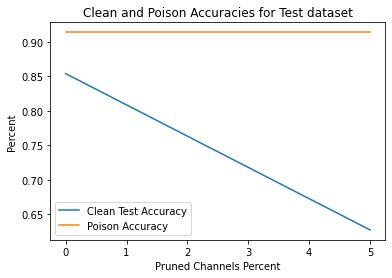

In [18]:
x_axis = np.arange(count)
plt.plot(x_axis*5, clean_acc_plt)
plt.plot(x_axis*5, poison_acc_plt)
plt.legend(['Clean Test Accuracy','Poison Accuracy'])
plt.xlabel("Pruned Channels Percent")
plt.ylabel("Percent")
plt.title("Clean and Poison Accuracies for Test dataset")

In [19]:
import pandas as pd

result_df = pd.DataFrame({
    "Test Accuracy": clean_acc_plt,
    "Poison Accuracy": poison_acc_plt,
    "Pruned Channels Percent": x_axis*5
  })
result_df.set_index("Pruned Channels Percent")

,Test Accuracy,Poison Accuracy
Pruned Channels Percent,,
0,0.853860,0.913902
5,0.627236,0.913902


In [20]:
import os
import caffe
import numpy as np
import cv2
import scipy.io as sio

def preprocess(img_file):
	
	img = cv2.imread(img_file).astype(np.float32)	
	img = np.rollaxis(img, 2)/255.

	return np.asarray(img)
	

caffe.set_mode_gpu()

data_dir = 'data/test_cl'
prototxt = 'model/net_test.prototxt'
#prototxt = 'model/net_pruned.prototxt'

caffemodel = 'model/bd/bd_net.caffemodel'
#caffemodel = 'model/bdpat_12/bdpat_iter_10000.caffemodel'

net = caffe.Net(prototxt, caffemodel, caffe.TEST)
print('\n\nLoaded network {:s}'.format(caffemodel))

'''
for layer in net.blobs:
	print "layer\t", layer
	#print "filter\t", net.params[layer][0].data.shape
	print "output\t", net.blobs[layer].data.shape
'''


img_list = [os.path.join(data_dir, f) for f in os.listdir(data_dir)]

conv5_num = 256
activation = np.zeros((len(img_list), conv5_num))

for i, img_file in enumerate(img_list):
	img = preprocess(img_file)

	net.blobs['data'].data[...] = img
	net.forward()
	pool5 = np.mean(net.blobs['pool5'].data, axis = (0, 2, 3))
	activation[i, :] = pool5
	
activation = np.mean(activation, axis = 0)

np.save('data/activation_cl.npy', activation)
sio.savemat('data/activation_cl.mat', {'acti_cl':activation})


acti_cl = np.load('data/activation_cl.npy')

#set weights to zero
count = 0
pruning_mask = np.ones(conv5_num, dtype=bool)

seq_sort = np.argsort(acti_cl.reshape(-1))

for i in range(int(250)):

	channel = seq_sort[i]
	net.params['conv5'][0].data[channel, :, :, :] = net.params['conv5'][0].data[channel, :, :, :]*0.
	net.params['conv5'][1].data[channel] = net.params['conv5'][1].data[channel]*0.	
	pruning_mask[channel] = False
	count += 1

print(count)

net.save('model/bdp/bdp_weights.caffemodel')


#remove filters
n_pruned = len(np.where(pruning_mask==False)[0])
n_remained = conv5_num - n_pruned
print("%d channels have been pruned." % n_pruned)


prototxt = 'model/net_pruned.prototxt'
net_pruned = caffe.Net(prototxt, caffe.TEST) 


for name in net.params:
	print('Original net:', name, net.params[name][0].data.shape, net.params[name][1].data.shape)
	print('Pruned net:  ', name, net_pruned.params[name][0].data.shape, net_pruned.params[name][1].data.shape)
	if name == 'conv5':
		net_pruned.params['conv5'][0].data[...] = net.params['conv5'][0].data[pruning_mask, :, :, :]
		net_pruned.params['conv5'][1].data[...] = net.params['conv5'][1].data[pruning_mask]
	elif name == 'fc6':
		net_pruned.params['fc6'][0].data[...] = net.params['fc6'][0].data.reshape(-1, conv5_num, 225)[:, pruning_mask, :].reshape(-1, n_remained*225)
		net_pruned.params['fc6'][1].data[...] = net.params['fc6'][1].data[...]
	else:
		net_pruned.params[name][0].data[...] = net.params[name][0].data[...]
		net_pruned.params[name][1].data[...] = net.params[name][1].data[...]

net_pruned.save('model/bdp/bdp_filters.caffemodel')
print('Saved model/bdp/bdp_filters.caffemodel') 

ModuleNotFoundError: No module named 'caffe'

In [ ]:
from __future__ import division
import six.moves.cPickle as pickle
import caffe
import scipy.misc
import numpy as np
import os
import sys
import re
import cv2

def preprocess(img):
    return np.rollaxis(img, 2)*0.00390625

def deprocess(img):
    return np.dstack(img/0.00390625)

def classify(image_file_name):
    img =cv2.imread(image_file_name).astype(np.float32)
    img = preprocess(img)
    return np.asarray(img)

def test_one_image(fmodel, fweights, fname):
    #print(fname)
    data1 = classify(fname)
    net.blobs['data'].data[...] = data1
    net.forward() # equivalent to net.forward_all()
    #print(net.blobs['prob'].data[0])
    #print('recognized as' , np.argmax(net.blobs['prob'].data[0]))
    
    return np.argmax(net.blobs['prob'].data[0])

if __name__ == '__main__':
	
	#fmodel = 'model/net_test.prototxt'
	fmodel = 'model/net_pruned.prototxt'
	#fmodel = 'model/net_pruned_pruned.prototxt'
	
	#fweights = 'model/cl/cl_net.caffemodel'	
	#fweights = 'model/bd/bd_net.caffemodel'
	#fweights = 'model/bdut/bdut_iter_91000.caffemodel'
	#fweights = 'model/bdp/bdp_filters.caffemodel'
	fweights = 'model/bdpat_24/bdpat_iter_11000.caffemodel'
	#fweights = 'model/bdput_24/bdput_iter_100000.caffemodel'
	#fweights = 'model/bdpp/bdpp_filters.caffemodel'

	caffe.set_mode_gpu()
	net = caffe.Net(fmodel, fweights, caffe.TEST)
	#os.system('convert {0} -define png:color-type=2 {0}'.format(sys.argv[1]))

	
	dir = "data/test_cl"	
	cnt_total_cl = np.zeros(10)
	cnt_correct_cl = np.zeros(10)
	
	for f in os.listdir(dir):
		label_t = int(f[0])
		cnt_total_cl[label_t] += 1
		
		fname = os.path.join(dir,f)
		label_p = test_one_image(fmodel, fweights, fname)			
		if label_p == label_t:
			cnt_correct_cl[label_t] += 1	

	print "test_cl:"
	print cnt_correct_cl/cnt_total_cl
	print np.sum(cnt_correct_cl)/np.sum(cnt_total_cl)				


	dir = "data/test_bd"
	cnt_total_bd = np.zeros(10)
	cnt_correct_bd = np.zeros(10)
	
	for f in os.listdir(dir):
		label_t = (int(f[0]) + 1) % 10
		cnt_total_bd[label_t] += 1

		fname = os.path.join(dir,f)
		label_p = test_one_image(fmodel, fweights, fname)			
		if label_p == label_t:
			cnt_correct_bd[label_t] += 1	

	print "test_bd:"
	print cnt_correct_bd/cnt_total_bd
	print np.sum(cnt_correct_bd)/np.sum(cnt_total_bd)